In [2]:
!pip install transformers
import transformers

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, AdamW
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
train_path ='/kaggle/input/nlp-getting-started/train.csv'
test_path ='/kaggle/input/nlp-getting-started/test.csv'

In [5]:
train_df = pd.read_csv(train_path);
test_df = pd.read_csv(test_path)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
pd.set_option('display.max_colwidth', None)
print(train_df['text'].head(5))
pd.reset_option('display.max_colwidth')

0                                                                    Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                   Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                        13,000 people receive #wildfires evacuation orders in California 
4                                                 Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
Name: text, dtype: object


In [7]:
# Assuming 'df' is your DataFrame and it contains a column named 'target'
train_df['target_label'] = train_df['target'].apply(lambda x: 'real disaster' if x == 1 else 'not real disaster')


In [8]:
# To check the result
train_df.shape

(7613, 6)

In [9]:
train_df.target

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [10]:
train_df.head()

,id,keyword,location,text,target,target_label
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,real disaster
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,real disaster
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,real disaster
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,real disaster
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,real disaster


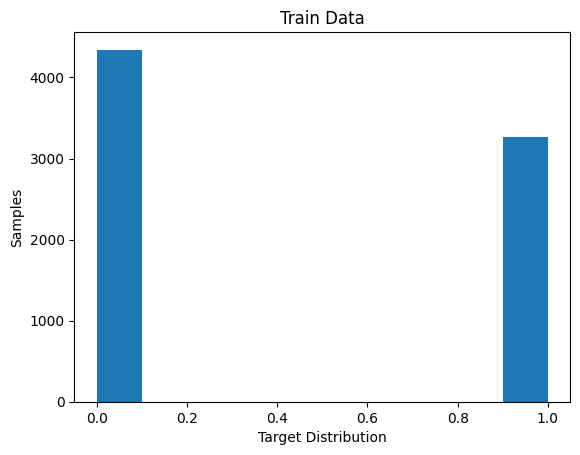

In [11]:
plt.title('Train Data')
plt.xlabel('Target Distribution')
plt.ylabel('Samples')
plt.hist(train_df.target)
plt.show()

# Lets Preprocess Data 
1. Basic Cleaning:
Convert all text to lowercase.
Remove URLs.
Remove HTML tags.
Remove special characters, numbers, and punctuations.
Remove extra whitespaces.
2. Tokenization:
Split the text into individual words (tokens).
3. Stopwords Removal:
Remove common words (like "and", "the", etc.) that may not contribute much to the meaning.
4. Stemming/Lemmatization:
Reduce words to their root form (e.g., "running" becomes "run").
5. Padding/Truncating Sequences:
Ensure all text inputs are of the same length by padding shorter sequences and truncating longer ones.

In [12]:
import spacy
import re

# Load the English language model
nlp = spacy.load('en_core_web_sm')

def decontracted(text):
    # Define this function to handle common contractions (example implementation)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"(\w+)'(\w+)", r"\1 \2", text)
    return text

# Define the preprocessing function
def preprocessing(text):
    #print(text)
    
    # Remove hashtags
    text = text.replace('#', '')
   # print("Hashtags removed:", text)
    
    # Decontract words (make sure to define this function or adjust as needed)
    text = decontracted(text)
   # print("Decontracted:", text)
    
    # Remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Remove URLs
    text = re.sub(r'http[s]?:(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
   # print("Special characters removed:", text)
    
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^A-z]', ' ', text.lower())
    #print("Lowercased and non-alphabetic characters removed:", text)
    
    # Process text with spaCy
    doc = nlp(text)
    
    # Tokenization, lemmatization, and stop words removal
    tokens = [token.lemma_ for token in doc if not token.is_stop and len(token) > 2]
    #provides the lemma of the token. Lemmatization is the process of reducing a word to its base or root form
    #len(token) > 2 This condition filters out tokens that have a length of 2 or fewer characters
    
    # Join tokens into a single string and normalize whitespace
    result = ' '.join(tokens)
    result = re.sub('\s+', ' ', result)  # Replace multiple spaces with a single space
    
    return result.strip()

# Example usage
demotext = "Hey there! Can't believe this #disaster happened in 2024. Check out https://example.com for more info. Contact us at info@example.com."
output_spacy = preprocessing(demotext)
print("spaCy output:", output_spacy)


spaCy output: hey believe disaster happen check info contact


In [13]:
train_df.text = train_df.text.apply(lambda x : preprocessing(x))
print("done")

done


In [14]:
test_df.text = test_df.text.apply(lambda x : preprocessing(x))
print("done")

done


# Loading BertTokenizer
It is based on WordPiece Approach

In [15]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

# This method initializes a tokenizer using a pre-trained BERT model with specific configurations. 


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

In [16]:
# Example text
demotext = "Hello, how are you doing today?"

# Tokenize the text
encoded_input = tokenizer(demotext, return_tensors='pt')

print(encoded_input)


{'input_ids': tensor([[ 101, 7592, 1010, 2129, 2024, 2017, 2725, 2651, 1029,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


# BERT Encoding

Data is encoded according to BERT requirement.There is a very helpful function called encode_plus provided in the Tokenizer class. It can seamlessly perform the following operations:

Tokenize the text
Add special tokens - [CLS] and [SEP]

Add special tokens - [CLS] and [SEP]

create token IDs

Pad the sentences to a common length

Create attention masks for the above PAD tokens

In [17]:
# Function to encode text data
def bert_encode(data, tokenizer, maximum_length):
    input_ids = []
    attention_masks = []
    for text in data['text']:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'].squeeze().numpy())
        attention_masks.append(encoded['attention_mask'].squeeze().numpy())
    return np.array(input_ids), np.array(attention_masks)

## Input are 2 Numpy array. Let me briefly go over them:

1) input_ids : list of token ids to be fed to a model

2) attention_masks: list of indices specifying which tokens should be attended to by the model.The input sequences are denoted by 1 and the padded ones by 0. These masks help to differentiate between the two.

In [18]:
input_ids, attention_masks = bert_encode(train_df, tokenizer, maximum_length=60)
labels = train_df['target'].values 

In [19]:
print(input_ids)

[[  101 15046  3114 ...     0     0     0]
 [  101  3224  2543 ...     0     0     0]
 [  101  6319  3198 ...     0     0     0]
 ...
 [  101 11396 12779 ...     0     0     0]
 [  101  2610  8556 ...     0     0     0]
 [  101  2397  2188 ...     0     0     0]]


In [20]:
print(attention_masks)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [21]:
print(labels);

[1 1 1 ... 1 1 1]


In [22]:
# Define a PyTorch Dataset
class BertDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = torch.tensor(input_ids)
        self.attention_masks = torch.tensor(attention_masks)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

## Prepare Dataset

In [23]:
# Split the data into training and validation sets
dataset = BertDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## DataLoader

In [24]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [25]:
# empty the cache from cuda device
torch.cuda.empty_cache()
print("cache emptied")

cache emptied


## Creating Custom Model with a BERT pretrained model

In [26]:
import torch
import torch.nn as nn
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-large-uncased'):   ## THIS IS THE PRETRAINED MODEL NAME
        super(BertClassifier, self).__init__()
        
        # Load the BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)
        
        # Define additional layers
        self.dense = nn.Linear(self.bert.config.hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        # Forward pass through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get the [CLS] token's embedding
        pooled_output = outputs.pooler_output
        
        # Pass through additional layers
        x = self.dense(pooled_output)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        
        return x

In [27]:
import torch.optim as optim

# Initialize the model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = BertClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

cuda


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [28]:
print(model)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

## Training and Validation

In [29]:
# Training and evaluation function
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    
    for epoch in range(epochs):
        print("starting epochs")
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        batch_counter=0;
        
        for batch in train_loader:
            batch_counter+=1;
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predictions = (outputs > 0.5).long()
            
            correct_train += (predictions.squeeze() == labels).sum().item()
            total_train += labels.size(0)
            
#             if batch_counter % 20 == 0:                
#                 t_accuracy = (correct_train / total_train) * 100
#                 print(f"Batch {batch_counter} | Train Loss: {train_loss:.5f} | Train Accuracy: {t_accuracy:.2f}%")
            
        
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = (correct_train / total_train) * 100
        print("going to validate now")
        
        # Evaluation
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()
                predictions = (outputs > 0.5).long()
                correct_val += (predictions.squeeze() == labels).sum().item()
                total_val += labels.size(0)
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = (correct_val / total_val) * 100
        
        # Print metrics
        print(f'Epoch {epoch + 1}/{epochs}'
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%"'
              f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


In [30]:
# Train and evaluate the model
train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs=4)

starting epochs
going to validate now
Epoch 1/4
Train Loss: 0.6929, Train Accuracy: 57.24%
Validation Loss: 0.6931, Validation Accuracy: 56.66%
starting epochs
going to validate now
Epoch 2/4
Train Loss: 0.6931, Train Accuracy: 57.13%
Validation Loss: 0.6931, Validation Accuracy: 56.66%
starting epochs
going to validate now
Epoch 3/4
Train Loss: 0.6931, Train Accuracy: 57.13%
Validation Loss: 0.6931, Validation Accuracy: 56.66%
starting epochs
going to validate now
Epoch 4/4
Train Loss: 0.6931, Train Accuracy: 57.13%
Validation Loss: 0.6931, Validation Accuracy: 56.66%


## Working with test Data

In [31]:
test_input_ids, test_attention_masks = bert_encode(test_df, tokenizer, maximum_length=60)

In [32]:
import torch
from torch.utils.data import Dataset

class BertTestDataset(Dataset):
    def __init__(self, input_ids, attention_masks):
        self.input_ids = torch.tensor(input_ids)
        self.attention_masks = torch.tensor(attention_masks)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx]
        }


In [33]:
# Create test dataset and dataloader
test_dataset = BertTestDataset(test_input_ids, test_attention_masks)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [34]:
def predict(model, dataloader, device):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_masks)
            predictions = (outputs > 0.5).long().cpu().numpy()
            all_predictions.extend(predictions)

    return np.array(all_predictions)

In [35]:
results = predict(model, test_loader, device)
print("results found")

results found


In [36]:
output_df = pd.DataFrame({
    'id': test_df['id'],
    'target': results.flatten()  # Flatten if results is a 2D array
})

# Save predictions to CSV
output_df.to_csv('submission.csv', index=False)